## COVID-19 Classifier from X-Ray Images

#### Tasks

- [✔️] Exploratory Data Analysis
- [✔️] Image augumentation
- [✔️] Base CNN model accuracy calculation
- [✔️] Base CNN model with lower imbalance data
- [✔️] RESNET 50 model accuracy calculation
- [✔️] EfficientNet B4 accuracy calculation
- [✔️] AUC Score comparision
- [⚫] Results

#### Version Information

- v1 :
    - Completed exploratory data analysis of given metadata
    - Completed exploratory data analysis of provided images
    - Inferences of both EDA explained

- v2 :
    - Code cleaning
    - Output cleaning

- v3 :
    - Completed Image Augumentation using Keras ImageDataGenerator
    - Completed training of base CNN model on data
    - Accuracy inference of base CNN model completed
    
- v4 :
    - Trained base CNN model on balanced data
    - Inferenced accuracy of base CNN model on balanced data
    - Trained ResNet 50 model on data
    - Inferenced accuracy of ResNet 50 model
    
- v5 :
    - Because of severe class imbalance, metric for model training and validation is changed from accuracy -> AUC ROC
    - [Really Good Article on choosing evaluation metrics](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
    - Trained EfficientNet B4 model on data
    - Inferenced accuracy of EfficientNet B4 model
    - AUC score comparisions of all trained models
    
- v6 :
    - Added multiple metrics for better view of model comparison
    - Added numpy and tensorflow seeding for reproducible results

- v7 :
    - Code cleaning, debugging

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# v1
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# v3
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import *
# v4

ACCURACY_LIST = []
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalMaxPooling2D
from keras.models import Model

# v5
!pip install efficientnet
from efficientnet.keras import EfficientNetB4
from keras import backend as K

# v6
# Get reproducible results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

ModuleNotFoundError: No module named 'keras'

In [2]:
metadata = pd.read_csv('/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv')

metadata.sample(10)

Unnamed: 0               X_ray_image_name     Label Dataset_type  \
4519        4519   person692_bacteria_2589.jpeg  Pnemonia        TRAIN   
3147        3147   person325_bacteria_1500.jpeg  Pnemonia        TRAIN   
3037        3037  person1945_bacteria_4872.jpeg  Pnemonia        TRAIN   
712          712      NORMAL2-IM-0490-0001.jpeg    Normal        TRAIN   
5411        5434      NORMAL2-IM-0288-0001.jpeg    Normal         TEST   
2126        2126  person1423_bacteria_3650.jpeg  Pnemonia        TRAIN   
5065        5065      person973_virus_1647.jpeg  Pnemonia        TRAIN   
2639        2639  person1517_bacteria_3968.jpeg  Pnemonia        TRAIN   
3821        3821   person413_bacteria_1831.jpeg  Pnemonia        TRAIN   
416          416              IM-0616-0001.jpeg    Normal        TRAIN   

     Label_2_Virus_category Label_1_Virus_category  
4519                    NaN               bacteria  
3147                    NaN               bacteria  
3037                    NaN               bacteria  
712                     NaN                    NaN  
5411                    NaN                    NaN  
2126                    NaN               bacteria  
5065                    NaN                  Virus  
2639                    NaN               bacteria  
3821                    NaN               bacteria  
416                     NaN                    NaN

In [3]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


Unnamed: 0             X_ray_image_name     Label Dataset_type  \
5675        5698  person112_bacteria_539.jpeg  Pnemonia         TEST   
5807        5830      person49_virus_101.jpeg  Pnemonia         TEST   
5455        5478    NORMAL2-IM-0195-0001.jpeg    Normal         TEST   
5609        5632  person134_bacteria_644.jpeg  Pnemonia         TEST   
5798        5821      person57_virus_113.jpeg  Pnemonia         TEST   
5597        5620  person139_bacteria_661.jpeg  Pnemonia         TEST   
5895        5918   person1650_virus_2854.jpeg  Pnemonia         TEST   
5671        5694  person113_bacteria_543.jpeg  Pnemonia         TEST   
5590        5613  person140_bacteria_668.jpeg  Pnemonia         TEST   
5869        5892   person1678_virus_2895.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
5675                    NaN               bacteria  
5807                    NaN                  Virus  
5455                    NaN                    NaN  
5609                    NaN               bacteria  
5798                    NaN                  Virus  
5597                    NaN               bacteria  
5895                    NaN                  Virus  
5671                    NaN               bacteria  
5590                    NaN               bacteria  
5869                    NaN                  Virus

## Exploratory Data Analysis

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Source : [Exploratory Data Analysis](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)

In [4]:
# Null value calculation
print(f"Count of null values in train :\n{train_data.isnull().sum()}")
print(f"Count of null values in test :\n{test_data.isnull().sum()}")

Count of null values in train :
Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64
Count of null values in test :
Unnamed: 0                  0
X_ray_image_name            0
Label                       0
Dataset_type                0
Label_2_Virus_category    624
Label_1_Virus_category    234
dtype: int64


In [5]:
# Substitute null values with string unknown
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')

train_fill.sample(10)

Unnamed: 0               X_ray_image_name     Label Dataset_type  \
4724        4724      person605_virus_1169.jpeg  Pnemonia        TRAIN   
991          991      NORMAL2-IM-0978-0001.jpeg    Normal        TRAIN   
1601        1601  person1040_bacteria_2974.jpeg  Pnemonia        TRAIN   
428          428              IM-0606-0001.jpeg    Normal        TRAIN   
2080        2080  person1271_bacteria_3231.jpeg  Pnemonia        TRAIN   
4768        4768   person870_bacteria_2792.jpeg  Pnemonia        TRAIN   
4352        4352   person549_bacteria_2305.jpeg  Pnemonia        TRAIN   
2690        2690  person1720_bacteria_4545.jpeg  Pnemonia        TRAIN   
2914        2914   person265_bacteria_1236.jpeg  Pnemonia        TRAIN   
3971        3971   person502_bacteria_2122.jpeg  Pnemonia        TRAIN   

     Label_2_Virus_category Label_1_Virus_category  
4724                unknown                  Virus  
991                 unknown                unknown  
1601                unknown               bacteria  
428                 unknown                unknown  
2080                unknown               bacteria  
4768                unknown               bacteria  
4352                unknown               bacteria  
2690                unknown               bacteria  
2914                unknown               bacteria  
3971                unknown               bacteria

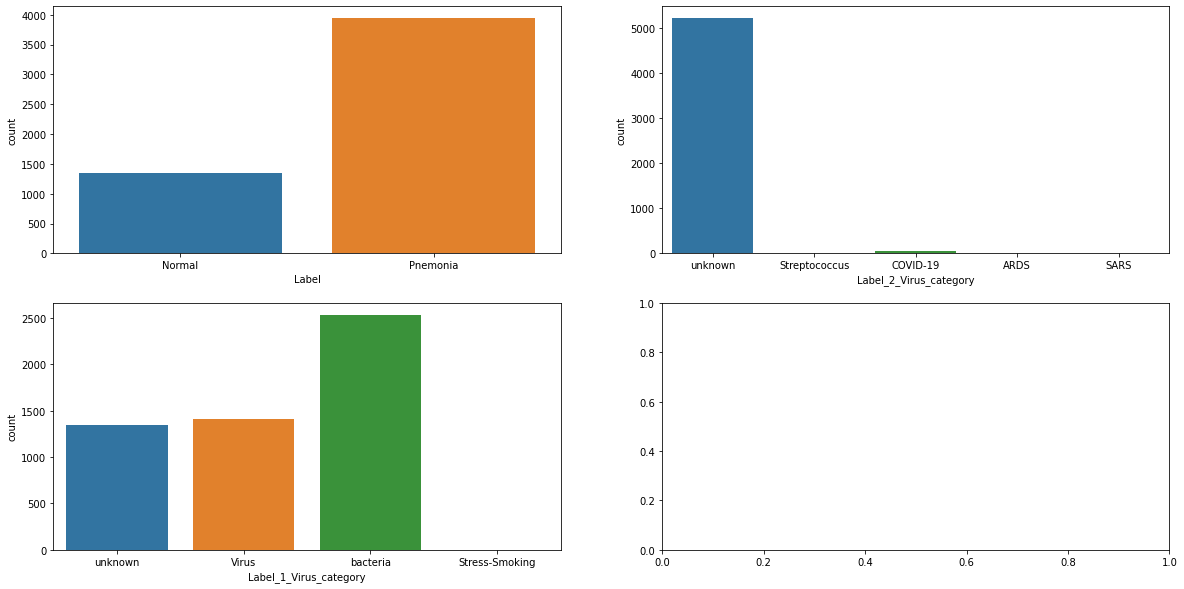

In [6]:
# Count plot for 3 attributes with unknown variable addition
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0])
plt.show()

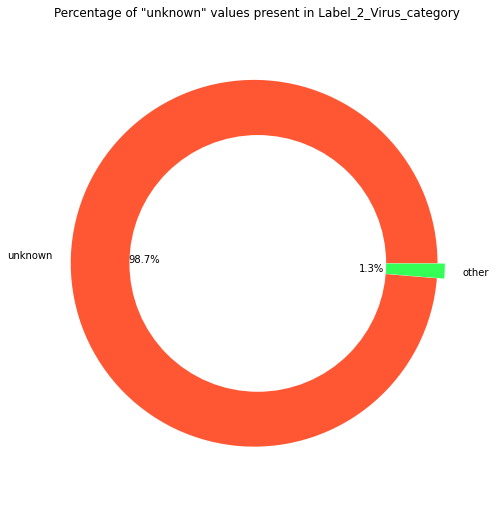

In [7]:
# Pie chart representation of Label_2_Virus_category values

colors = ['#ff5733', '#33ff57']
explode = [0.02, 0.02]

values = ['unknown', 'other']
percentages = [100 * (train_fill[train_fill[targets[1]] == 'unknown'].shape[0]) / train_fill.shape[0],
              100 * (train_fill[train_fill[targets[1]] != 'unknown'].shape[0]) / train_fill.shape[0]]

fig1, ax1 = plt.subplots(figsize=(7, 7))

plt.pie(percentages, colors=colors, labels=values,
        autopct='%1.1f%%', startangle=0, explode=explode)
fig = plt.gcf()
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.title('Percentage of "unknown" values present in Label_2_Virus_category')
plt.show()

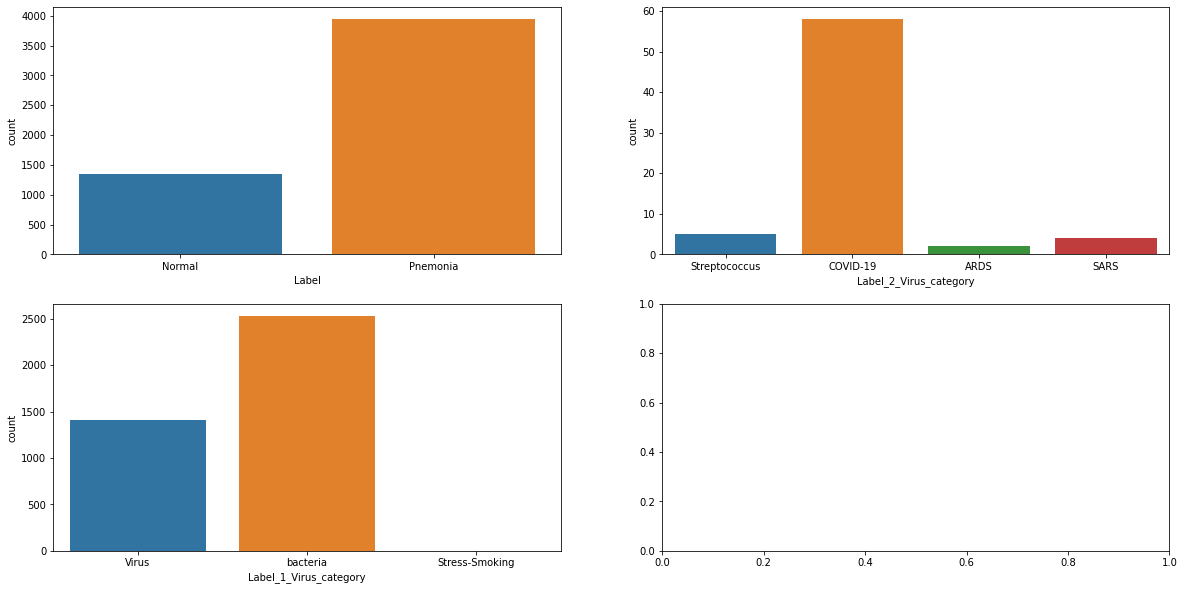

In [8]:
# Count plot for 3 target variables without filling unknown variable
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_data, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_data, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_data, ax=ax[1, 0])
plt.show()

In [9]:
print(f"Label = Normal Cases : {train_data[train_data['Label'] == 'Normal'].shape[0]}")
print(f"""Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Pnemonia')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")
print(f"""Label = Normal + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Normal')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")

Label = Normal Cases : 1342
Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : 58
Label = Normal + Label_2_Virus_category = COVID-19 cases : 0


### Inference from count plots and Pie chart

- All COVID-19 patients are classified with attribute Label as Pnemonia. None of them is classified as normal. 
- In target "Label_2_Virus_category", "unknown" value is associated with majority of images
- Unknown values consist of 98.7 % of total cases while COVID-19 value consist of less than 1.3 % of total cases.
- Even if we train a model to classify Label_2_virus_category with 98.7 % accuracy, it will be highly inefficient in detecting true positive COVID-19 cases.
- Thus we are going to construct a model which differentiates between (Normal) and (Pnemonia + COVID-19) Cases

### Analysis of Image files

In [10]:
TEST_FOLDER = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
TRAIN_FOLDER = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

assert os.path.isdir(TEST_FOLDER) == True
assert os.path.isdir(TRAIN_FOLDER) == True

In [11]:
sample_train_images = list(os.walk(TRAIN_FOLDER))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_train_images))

sample_test_images = list(os.walk(TEST_FOLDER))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(TEST_FOLDER, x), sample_test_images))

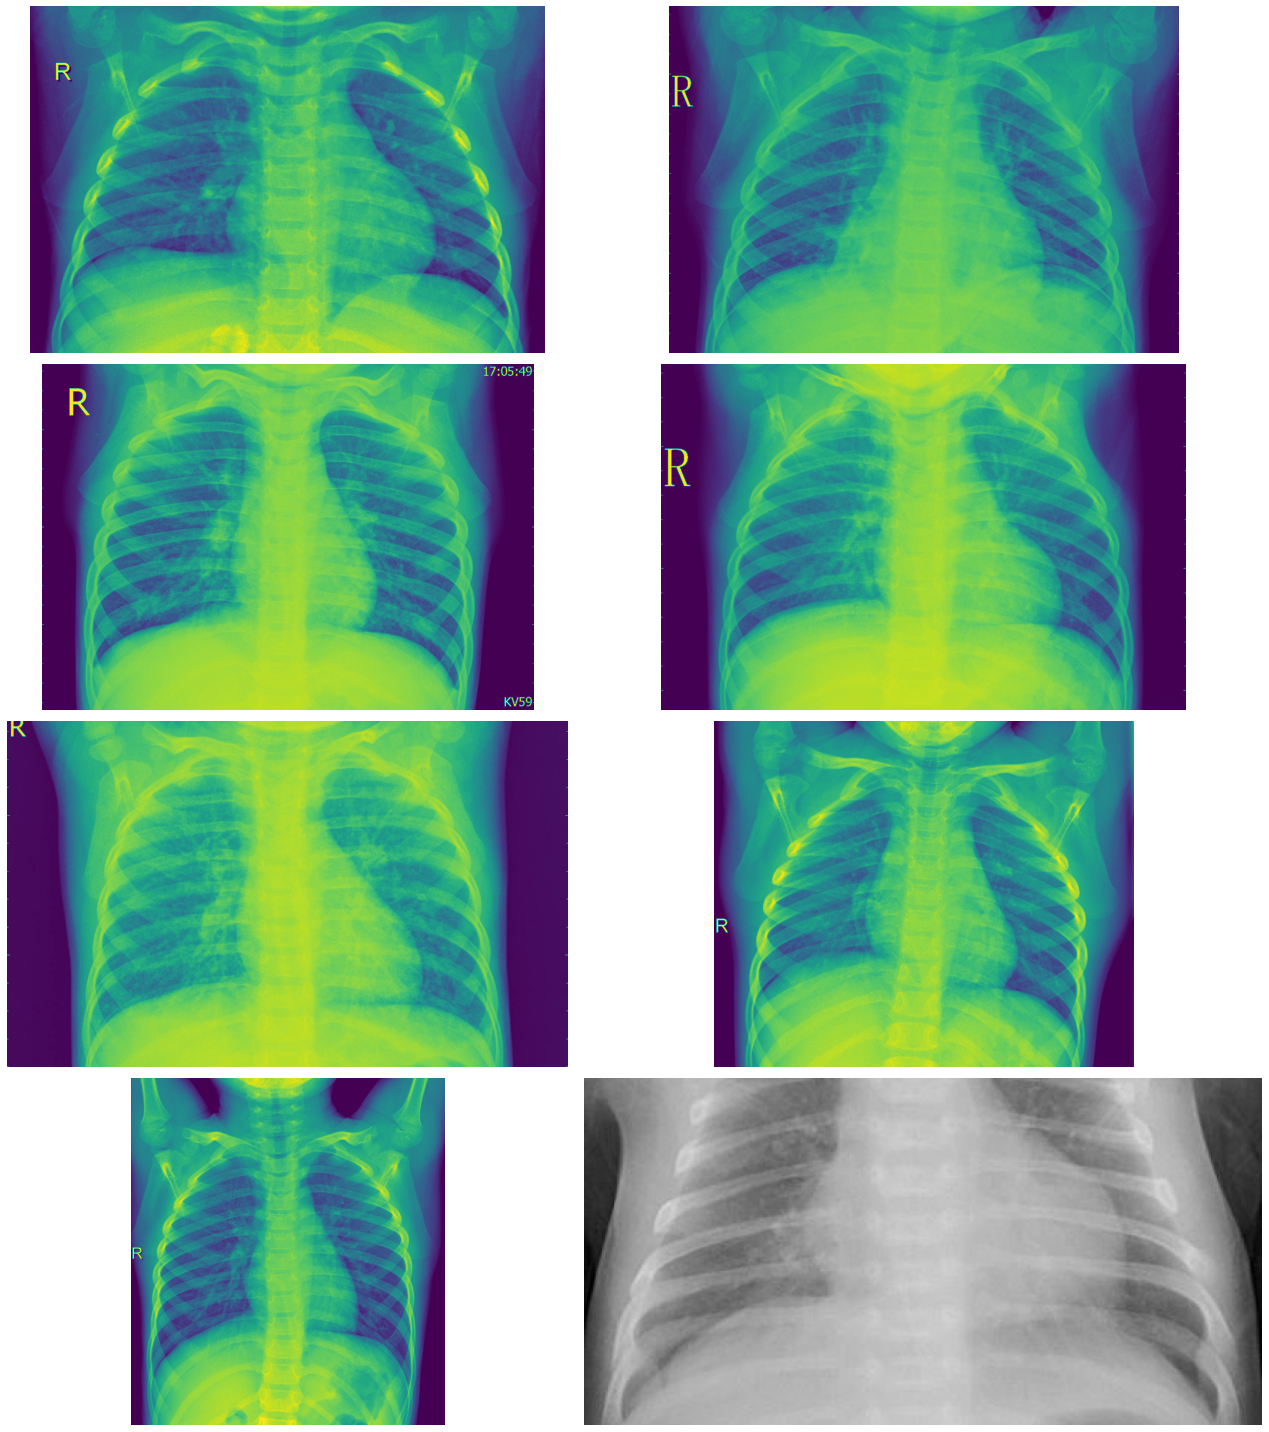

In [12]:
# Plot sample training images
plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()

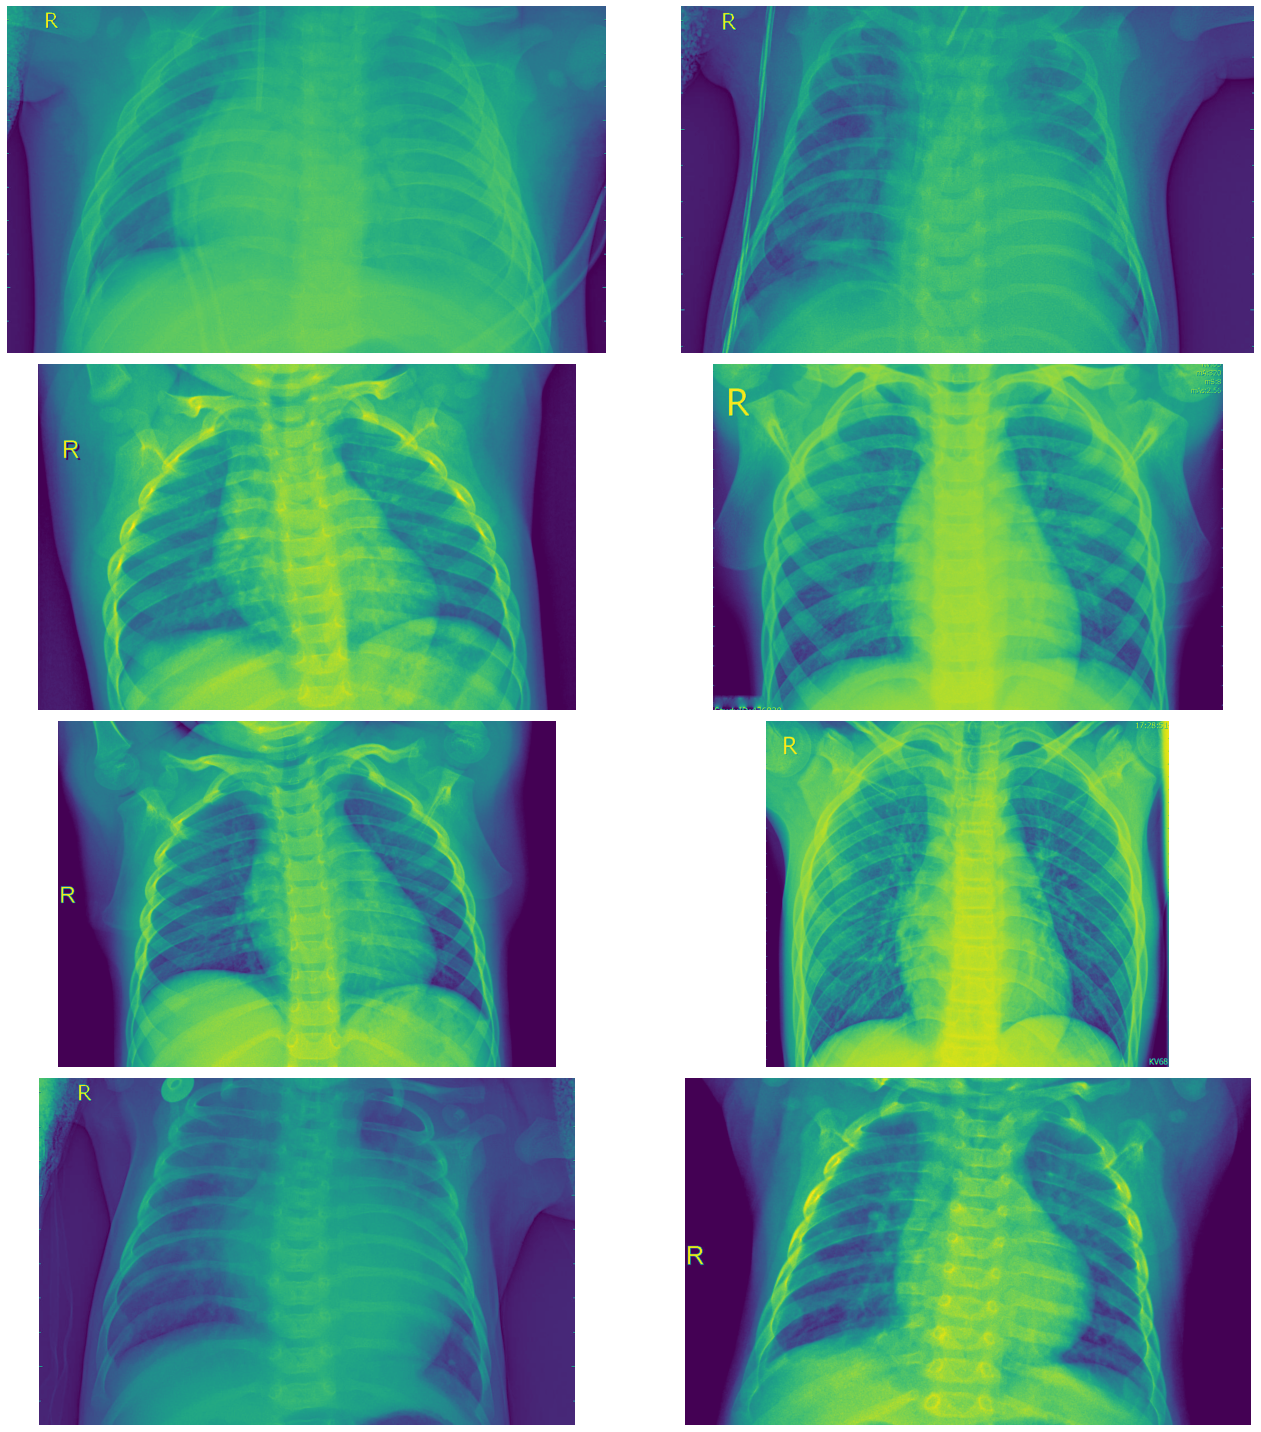

In [13]:
# Plot sample testing images
plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()

### Image Histograms

> An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.

Source : [Image histogram](https://en.wikipedia.org/wiki/Image_histogram)

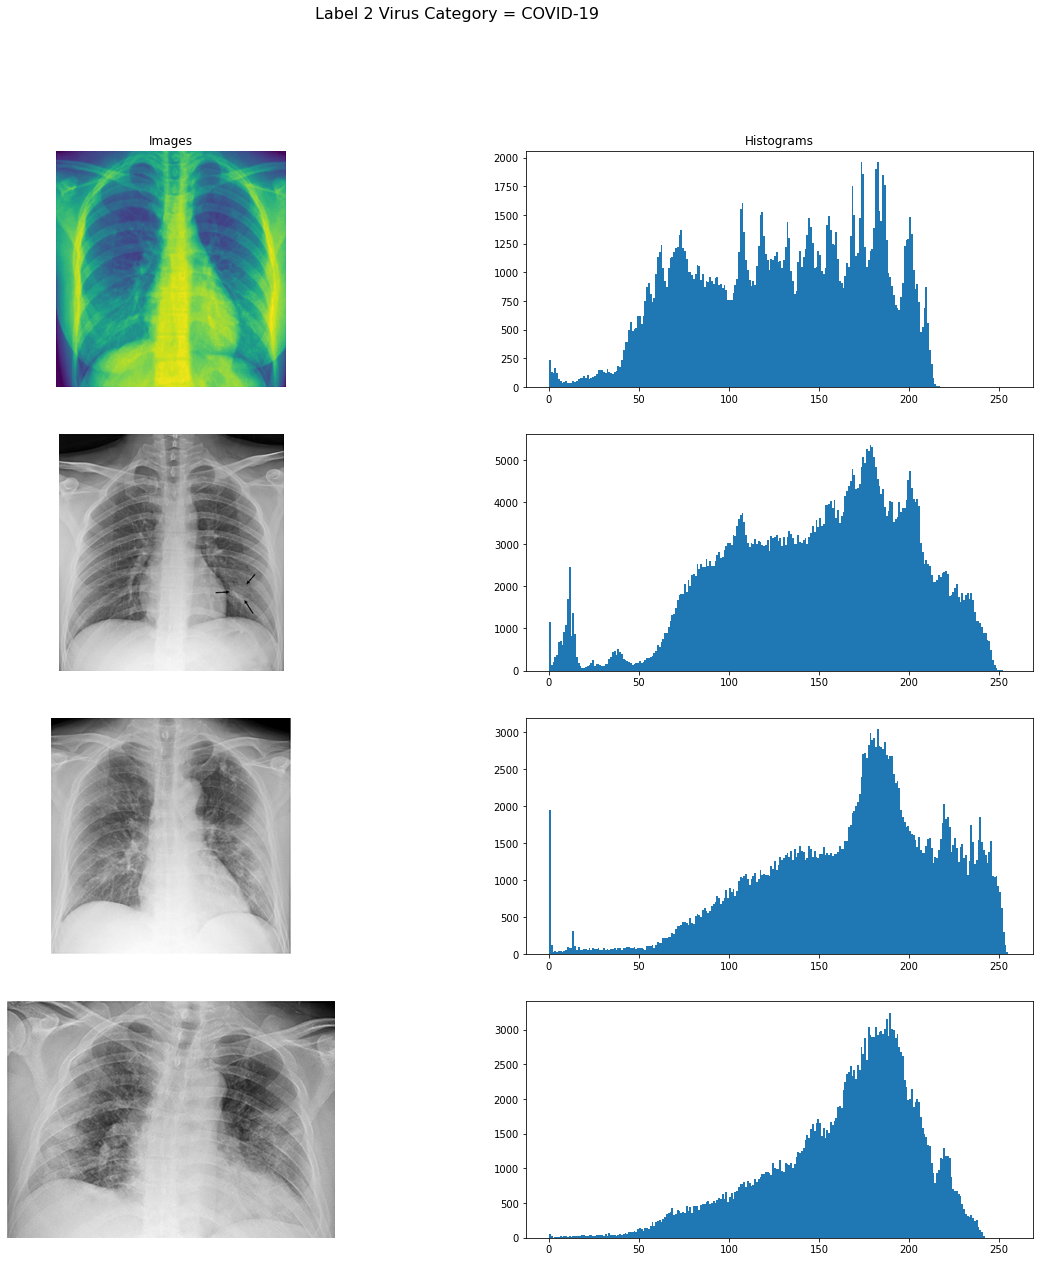

In [14]:
# Plot b/w image histograms of Label_2_Virus_category type "COVID-19" patients 
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

covid19_type_file_paths = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].values
sample_covid19_file_paths = covid19_type_file_paths[:4]
sample_covid19_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_covid19_file_paths))

for row, file_path in enumerate(sample_covid19_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()

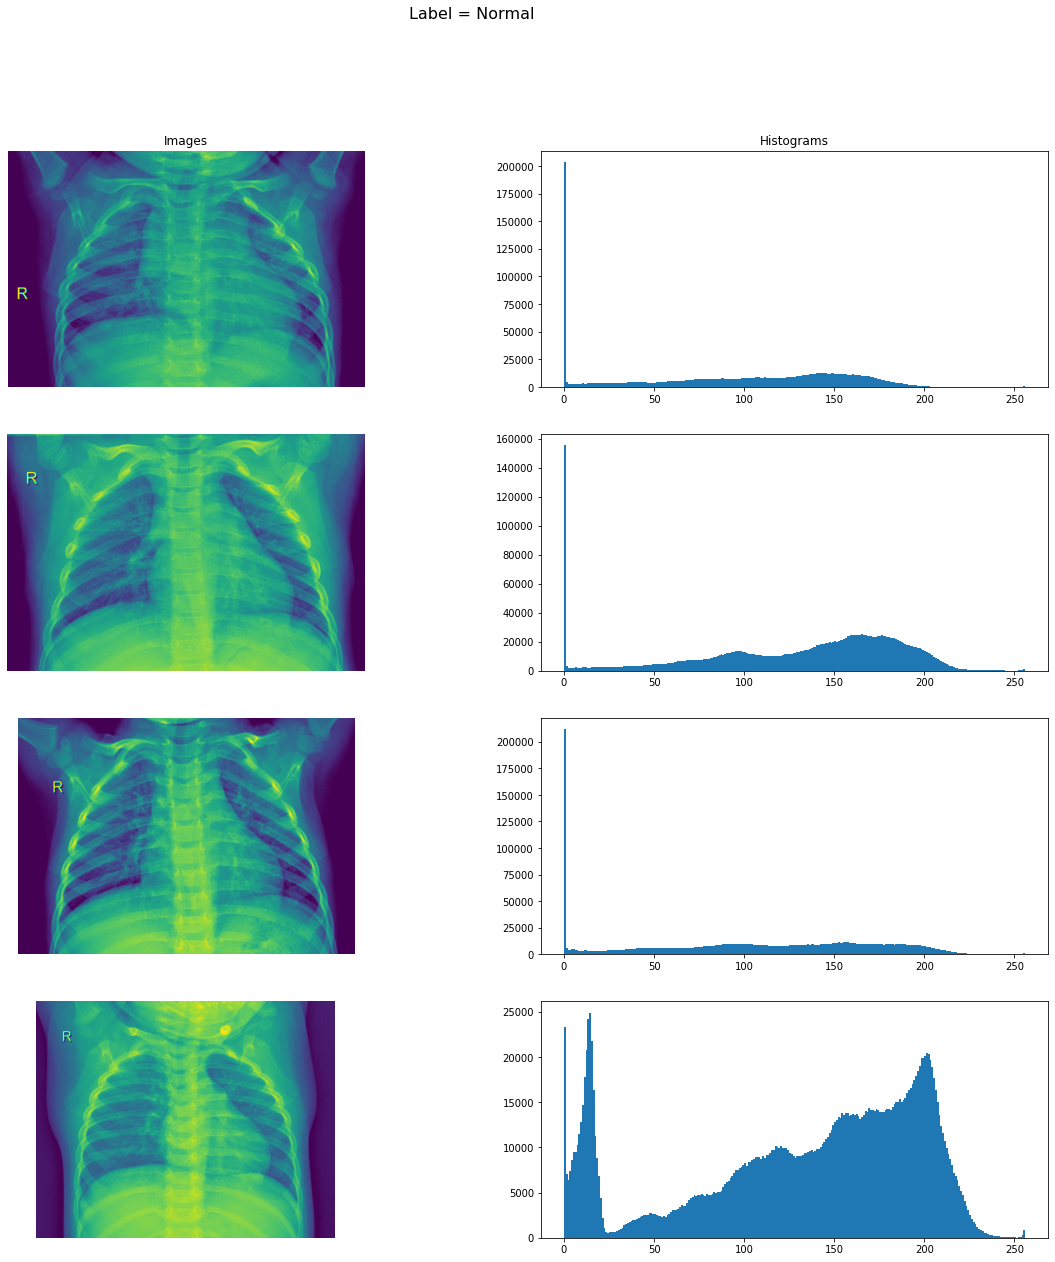

In [15]:
# Plot b/w image histograms of Label type "Normal" patients 
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

other_type_file_paths = train_data[train_data['Label'] == 'Normal']['X_ray_image_name'].values
sample_other_file_paths = other_type_file_paths[:4]
sample_other_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_other_file_paths))

for row, file_path in enumerate(sample_other_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = Normal', size=16)
plt.show()

### Inference

- From the sample images, seperated according to Label 2 Virus Category into COVID-19 and Other, we can infer the difference in image histograms
- The sample histograms of images having target as COVID-19 are mostly left-skewed histograms.
- The sample histograms of images which have Label value as Normal are mostly right skewed histograms (with exception of image 4).

## Image Augumentation

> Deep networks need large amount of training data to achieve good performance. To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc

Source : [Image Augumentation for Deep Learning](https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2)

- We will be using keras ImageDataGenerator's inbuilt image augumentation functionality for the process of image augumentation.

### Sort out the file names to be worked on

- From EDA, we decided to remove files with Label_2_Virus_category as NaN

In [16]:
# Generate the final train data from original train data with conditions refered from EDA inference
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)

Final train data shape : (1000, 7)


Unnamed: 0                X_ray_image_name   Label Dataset_type  \
649          649       NORMAL2-IM-0486-0001.jpeg  Normal        TRAIN   
663          663       NORMAL2-IM-0465-0001.jpeg  Normal        TRAIN   
297          297               IM-0493-0001.jpeg  Normal        TRAIN   
33            33               IM-0140-0001.jpeg  Normal        TRAIN   
1232        1232       NORMAL2-IM-1231-0001.jpeg  Normal        TRAIN   
1322        1322       NORMAL2-IM-1349-0001.jpeg  Normal        TRAIN   
1124        1124       NORMAL2-IM-1126-0001.jpeg  Normal        TRAIN   
1268        1268  NORMAL2-IM-1266-0001-0002.jpeg  Normal        TRAIN   
90            90               IM-0268-0001.jpeg  Normal        TRAIN   
19            19               IM-0166-0001.jpeg  Normal        TRAIN   

     Label_2_Virus_category Label_1_Virus_category    target  
649                     NaN                    NaN  negative  
663                     NaN                    NaN  negative  
297                     NaN                    NaN  negative  
33                      NaN                    NaN  negative  
1232                    NaN                    NaN  negative  
1322                    NaN                    NaN  negative  
1124                    NaN                    NaN  negative  
1268                    NaN                    NaN  negative  
90                      NaN                    NaN  negative  
19                      NaN                    NaN  negative

In [17]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=TEST_FOLDER,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None
)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


## Base CNN model accuracy calculation

- The given 69 images divided into 4 classes will be trained on a simple 3 convolution layers CNN

In [18]:
def scheduler(epoch):
    if epoch < 5:
        return 0.0001
    else:
        print(f"Learning rate reduced to {0.0001 * np.exp(0.5 * (5 - epoch))}")
        return 0.0001 * np.exp(0.5 * (5 - epoch))
    
custom_callback = LearningRateScheduler(scheduler)

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

In [19]:
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

In [20]:
history = model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   epochs=20,
                   callbacks=[custom_callback])

Epoch 1/20
125/125 [==============================] - 58s 463ms/step - loss: 0.2501 - tp: 2.0000 - fp: 13.0000 - tn: 952.0000 - fn: 33.0000 - accuracy: 0.9540 - precision: 0.1333 - recall: 0.0571 - auc: 0.5002 - val_loss: 0.5686 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5852
Epoch 2/20
125/125 [==============================] - 48s 381ms/step - loss: 0.1901 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 965.0000 - fn: 35.0000 - accuracy: 0.9650 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5261 - val_loss: 0.0265 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4499
Epoch 3/20
125/125 [==============================] - 48s 384ms/step - loss: 0.1877 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 965.0000 - fn: 35.0000 - accuracy: 0.9650 - precision: 0.

In [21]:
model.save('covid19_xray_base_cnn_model.h5')
ACCURACY_LIST.append(['Base CNN Model', history])

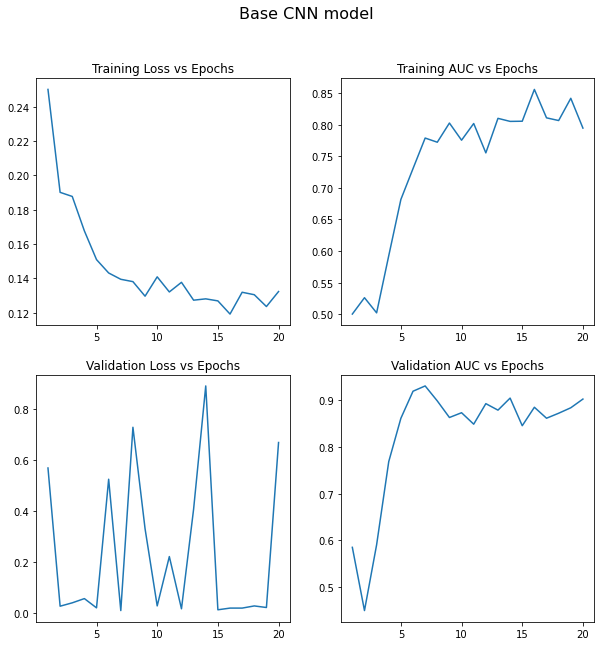

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Base CNN model', size=16)
plt.show()

### Inference from base CNN model accuracy and AUC
- Base CNN model
    - Train data accuracy = 95.4 %
    - Validation data accuracy = 97 %


- Possible reasons for stale accuracy on 20 epochs
    - Highly imbalance target variables
        - COVID-19 target value = positive rows have count as 58
        - Normal target value = negative rows have count as 1342
        - `100 * (1342 / 1400) ~ 95.86 %`
        - Even if model classifies all the images as "Normal" label, it would achieve 95.86 % accuracy
        
- V5 Changes:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Base CNN model with lower imbalance in data

- In this subsection, we try to remove 95.86 % imbalance present in the data
- We will remove 4 / 5 th of the Normal labelled images while keeping the count of COVID-19 labelled images same
- `1342 / 5 ~ 269; 269 / (269 + 58) ~ 82.26 % `
- To compensate for less number of training images, we increase the number of epochs

In [23]:
balanced_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

balanced_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

balanced_data_subset_normal = balanced_data[balanced_data['target'] == 'negative']
balanced_data_subset_covid = balanced_data[balanced_data['target'] == 'positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

print(f"Balanced train data shape {balanced_data_train.shape}")
print(f"Balanced validation data shape {balanced_data_validation.shape}")

Balanced train data shape (240, 7)
Balanced validation data shape (86, 7)


In [24]:
balanced_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_train,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

balanced_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_validation,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 240 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.


In [25]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

balanced_model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

balanced_model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

In [26]:
balanced_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)             

In [27]:
balanced_history = balanced_model.fit_generator(balanced_train_generator,
                                               epochs=30,
                                               validation_data=balanced_validation_generator,
                                               callbacks=[custom_callback])

Epoch 1/30
4/4 [==============================] - 12s 3s/step - loss: 0.6387 - tp: 3.0000 - fp: 31.0000 - tn: 172.0000 - fn: 34.0000 - accuracy: 0.7292 - precision: 0.0882 - recall: 0.0811 - auc: 0.4317 - val_loss: 0.6010 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 21.0000 - val_accuracy: 0.7558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6619
Epoch 2/30
4/4 [==============================] - 11s 3s/step - loss: 0.5731 - tp: 1.0000 - fp: 3.0000 - tn: 200.0000 - fn: 36.0000 - accuracy: 0.8375 - precision: 0.2500 - recall: 0.0270 - auc: 0.4595 - val_loss: 0.5183 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 21.0000 - val_accuracy: 0.7558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5864
Epoch 3/30
4/4 [==============================] - 11s 3s/step - loss: 0.5152 - tp: 0.0000e+00 - fp: 1.0000 - tn: 202.0000 - fn: 37.0000 - accuracy: 0.8417 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4260

In [28]:
balanced_model.save('covid19_xray_base_cnn_model_balanced.h5')
ACCURACY_LIST.append(['Balanced Base Model', balanced_history])

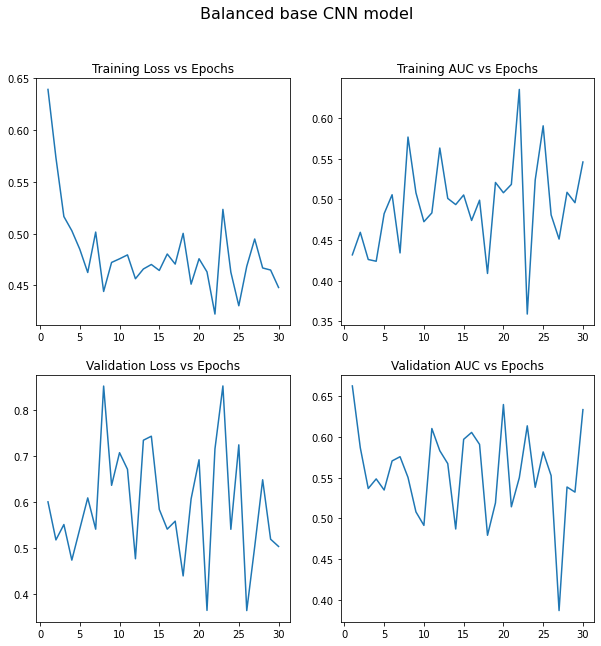

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Balanced base CNN model', size=16)
plt.show()

### Inferences

- Reducing imbalances results in reduced training images
- Accuracy reduced because of reduced training images
- Validation accuracy still remains stale even on reducing number of "Normal" labelled images
- V5 changes:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Training ResNet 50 on data

[ResNet Introduction and Architecture](https://neurohive.io/en/popular-networks/resnet/)

In [30]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

def output_custom_model(prebuilt_model):
    print(f"Processing {prebuilt_model}")
    prebuilt = prebuilt_model(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet')
    output = prebuilt.output
    output = GlobalMaxPooling2D()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=prebuilt.input, outputs=output)
    model.compile(optimizer='sgd', loss=binary_crossentropy,
              metrics=METRICS)
    return model

In [31]:
resnet_custom_model = output_custom_model(ResNet50)
resnet_history = resnet_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

Processing <function keras_modules_injection.<locals>.wrapper at 0x7fc00fc5c950>
94658560/94653016 [==============================] - 2s 0us/step
Epoch 1/20
125/125 [==============================] - 74s 589ms/step - loss: 0.5541 - tp: 5.0000 - fp: 62.0000 - tn: 903.0000 - fn: 30.0000 - accuracy: 0.9080 - precision: 0.0746 - recall: 0.1429 - auc: 0.5880 - val_loss: 0.4381 - val_tp: 2.0000 - val_fp: 5.0000 - val_tn: 372.0000 - val_fn: 21.0000 - val_accuracy: 0.9350 - val_precision: 0.2857 - val_recall: 0.0870 - val_auc: 0.6620
Epoch 2/20
125/125 [==============================] - 54s 434ms/step - loss: 0.2453 - tp: 5.0000 - fp: 20.0000 - tn: 945.0000 - fn: 30.0000 - accuracy: 0.9500 - precision: 0.2000 - recall: 0.1429 - auc: 0.7286 - val_loss: 1.4048 - val_tp: 14.0000 - val_fp: 309.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.2050 - val_precision: 0.0433 - val_recall: 0.6087 - val_auc: 0.4133
Epoch 3/20
125/125 [==============================] - 55s 437ms/step - loss: 0.25

In [32]:
resnet_custom_model.save('covid19_xray_resnet_50.h5')
ACCURACY_LIST.append(['ResNet 50', resnet_history])

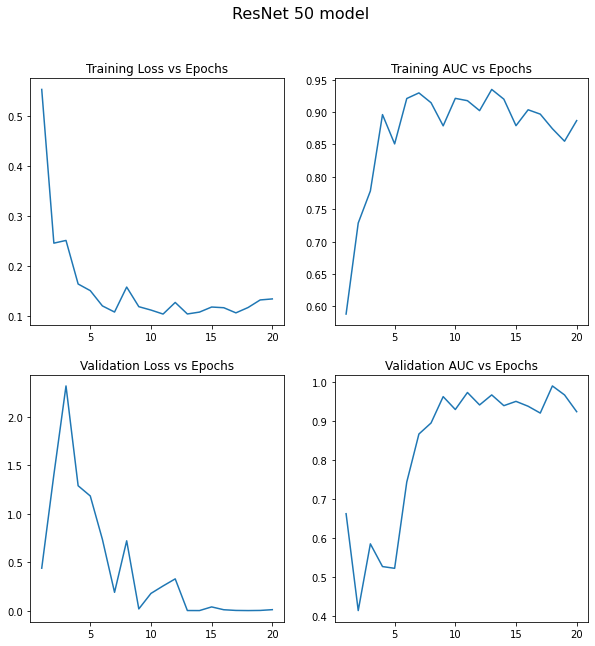

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('ResNet 50 model', size=16)
plt.show()

### Inference

- The effect of data imbalance is visible in validation accuracy measures
- Training accuracy of ResNet 50 is almost equal to base CNN model
- V5 Changes:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Training EfficientNet B4 on data

[EfficientNet Arxiv Paper](https://arxiv.org/abs/1905.11946)

- Reduced batch-size of data generators due to ResourceExhaustionError()

In [34]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

efficient_net_custom_model = output_custom_model(EfficientNetB4)
efficient_net_history = efficient_net_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

Processing <function EfficientNetB4 at 0x7fc00e5d8268>
71892992/71892840 [==============================] - 2s 0us/step
Epoch 1/20
125/125 [==============================] - 112s 897ms/step - loss: 0.3951 - tp: 5.0000 - fp: 75.0000 - tn: 890.0000 - fn: 30.0000 - accuracy: 0.8950 - precision: 0.0625 - recall: 0.1429 - auc: 0.5234 - val_loss: 0.1564 - val_tp: 0.0000e+00 - val_fp: 11.0000 - val_tn: 366.0000 - val_fn: 23.0000 - val_accuracy: 0.9150 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3754
Epoch 2/20
125/125 [==============================] - 65s 517ms/step - loss: 0.2269 - tp: 2.0000 - fp: 22.0000 - tn: 943.0000 - fn: 33.0000 - accuracy: 0.9450 - precision: 0.0833 - recall: 0.0571 - auc: 0.5841 - val_loss: 0.4327 - val_tp: 1.0000 - val_fp: 21.0000 - val_tn: 356.0000 - val_fn: 22.0000 - val_accuracy: 0.8925 - val_precision: 0.0455 - val_recall: 0.0435 - val_auc: 0.4747
Epoch 3/20
125/125 [==============================] - 65s 519ms/step - loss: 0.1993 - tp: 2.0

In [35]:
efficient_net_custom_model.save('covid19_xray_efficient_net_B4.h5')
ACCURACY_LIST.append(['EfficientNet B4', efficient_net_history])

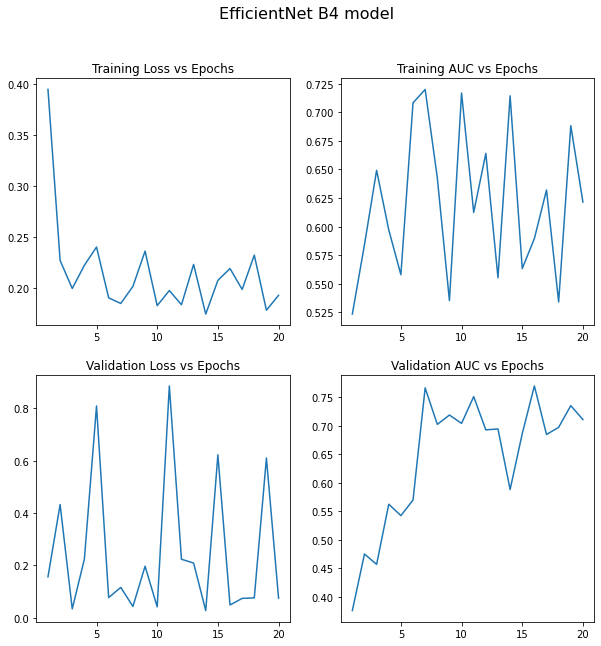

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('EfficientNet B4 model', size=16)
plt.show()

## Binary Accuracy and AUC score comparision

- As the data is imbalanced, more concentration will be given on AUC score comparision

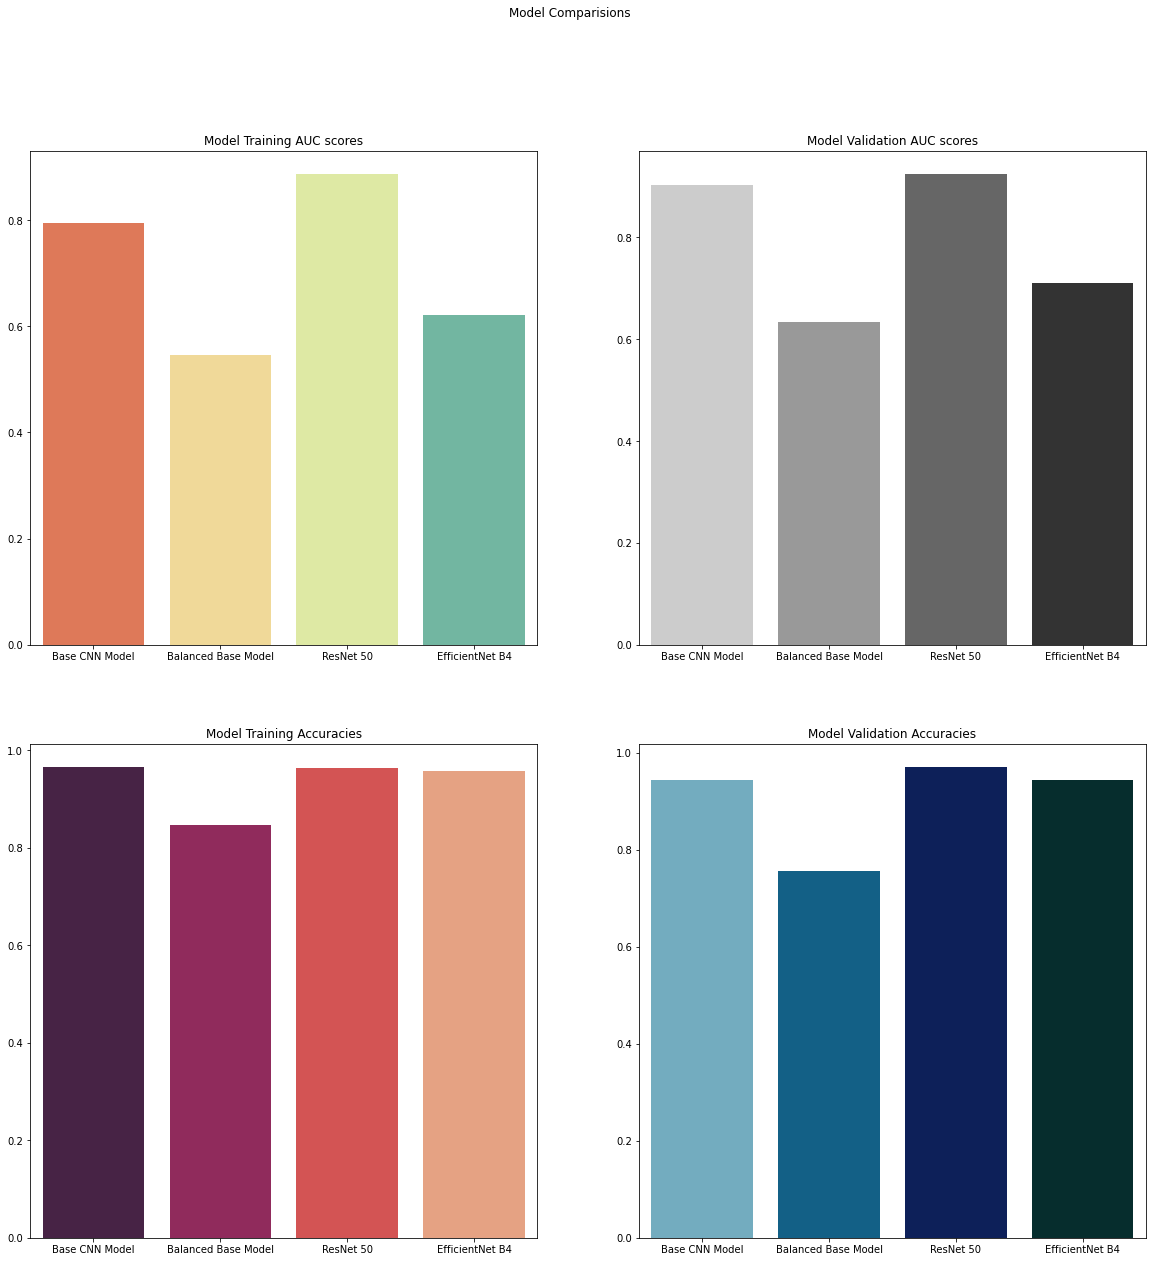

In [37]:
ACCURACY_LIST = np.array(ACCURACY_LIST)
model_names = ACCURACY_LIST[:, 0]
histories = ACCURACY_LIST[:, 1]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('auc')[-1], histories)), ax=ax[0, 0], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_auc')[-1], histories)), ax=ax[0, 1], palette='gist_yarg')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('accuracy')[-1], histories)), ax=ax[1, 0], palette='rocket')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_accuracy')[-1], histories)), ax=ax[1, 1], palette='ocean_r')
ax[0, 0].set_title('Model Training AUC scores')
ax[0, 1].set_title('Model Validation AUC scores')
ax[1, 0].set_title('Model Training Accuracies')
ax[1, 1].set_title('Model Validation Accuracies')
fig.suptitle('Model Comparisions')
plt.show()

## TP, FP, TN, FN model comparisions

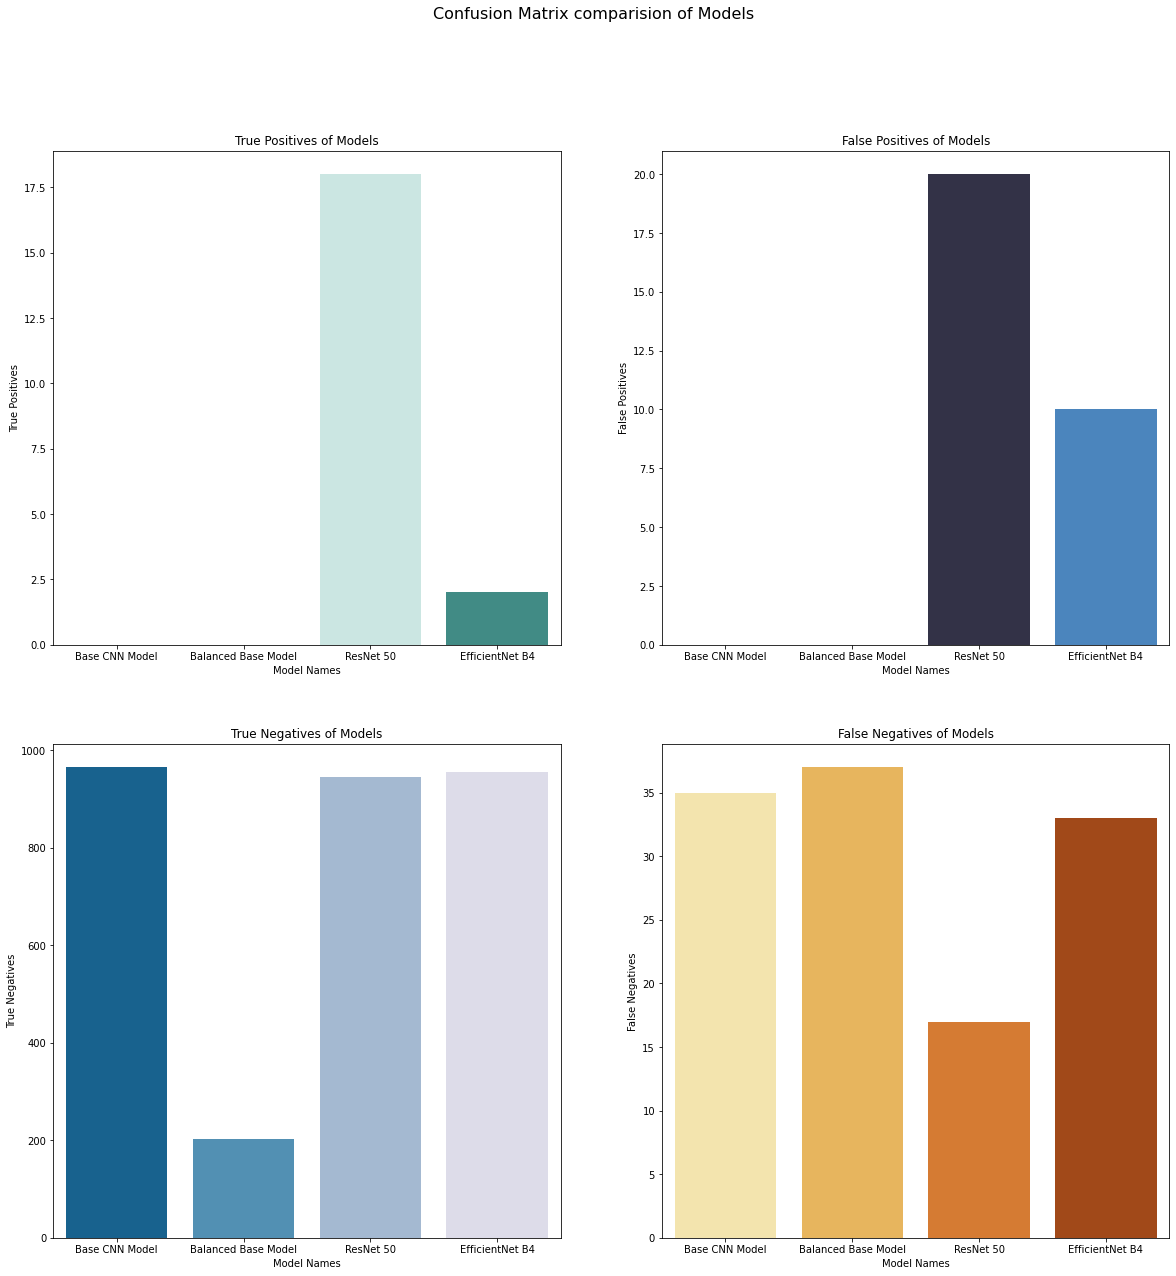

In [38]:
metric_dataframe = pd.DataFrame({
    'Model Names': model_names,
    'True Positives': list(map(lambda x: x.history.get('tp')[-1], histories)),
    'False Positives': list(map(lambda x: x.history.get('fp')[-1], histories)),
    'True Negatives': list(map(lambda x: x.history.get('tn')[-1], histories)),
    'False Negatives': list(map(lambda x: x.history.get('fn')[-1], histories))
})
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x='Model Names', y='True Positives', data=metric_dataframe, ax=ax[0, 0], palette='BrBG')
sns.barplot(x='Model Names', y='False Positives', data=metric_dataframe, ax=ax[0, 1], palette='icefire_r')
sns.barplot(x='Model Names', y='True Negatives', data=metric_dataframe, ax=ax[1, 0], palette='PuBu_r')
sns.barplot(x='Model Names', y='False Negatives', data=metric_dataframe, ax=ax[1, 1], palette='YlOrBr')
ax[0, 0].set_title('True Positives of Models')
ax[0, 1].set_title('False Positives of Models')
ax[1, 0].set_title('True Negatives of Models')
ax[1, 1].set_title('False Negatives of Models')
fig.suptitle('Confusion Matrix comparision of Models', size=16)
plt.show()

### Inference from metric comparisions

- ResNet 50 has the most AUC score out of all the models
- In our experiment, it is higly important for a model to correctly predict COVID-19 patient, thus it should have high True Positive score and low False Negative score
- ResNet 50 has the highest True Positive score and lowest False Negative score
- From the metric comparisions, ResNet 50 model performs better than other models in the experiment